In [1]:
import torch
import numpy as np
import torch.nn as nn

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=50):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
   


In [2]:
import sys
sys.path.append('../')
from models import sam_model_registry, SamPredictor
from Unet.models.unet import UNet
# Load model
sam_checkpoint = "../src/sam_pretrained/sam_vit_l_0b3195.pth"
model_type = "vit_l"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam = torch.nn.DataParallel(sam).cuda()
sam = sam.module

predictor = SamPredictor(sam)

UNet_checkpoint = "../Unet/save/Unet-RGB_transform_ratio_0.2/model_40.pth"
unet = UNet(3, 1)
unet = torch.nn.DataParallel(unet).cuda()
unet = unet.module
unet.load_state_dict(torch.load(UNet_checkpoint))
unet.eval();


IoU: 0.2101, IoU threshold: 0.2125


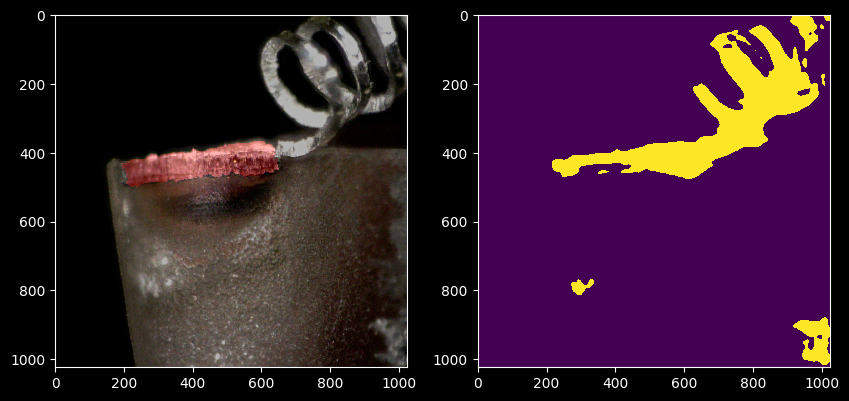

In [14]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from Unet.utils import iou_loss
# Load image
# display a specific image
random_image_path = "../src/dataset/Test/Turning_3/M5_2020_01_14_15_05_28_EDOF_image.png"

random_gt_path = random_image_path.replace("image", "label").replace("Test", "Test_gt")
image = np.array(Image.open(random_image_path).convert('RGB'))
gt = np.array(Image.open(random_gt_path).convert('L'))
overlay = cv2.addWeighted(np.array(image), 0.7, cv2.merge((gt, 0*gt, 0*gt)), 0.3, 0)
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(overlay)

# predict with unet
sigmoid = nn.Sigmoid()
image_tensor = transforms.ToTensor()(image)
image_tensor = image_tensor.unsqueeze(0).cuda()
outputs = unet(image_tensor)
outputs_lowres = nn.MaxPool2d(4)(outputs)
pre = (sigmoid(outputs)>0.5).float()
plt.subplot(1, 2, 2)
plt.imshow(pre.squeeze().cpu().detach().numpy())
iou = 1 - iou_loss(sigmoid(outputs), torch.from_numpy(gt/255).unsqueeze(0).unsqueeze(0).float().cuda()).item()
iou_threshold = 1 - iou_loss((sigmoid(outputs) > 0.5).float(), torch.from_numpy(gt/255).unsqueeze(0).unsqueeze(0).float().cuda()).item()
print(f"IoU: {iou:.4f}, IoU threshold: {iou_threshold:.4f}")

IoU: 0.2657, IoU threshold: 0.2657


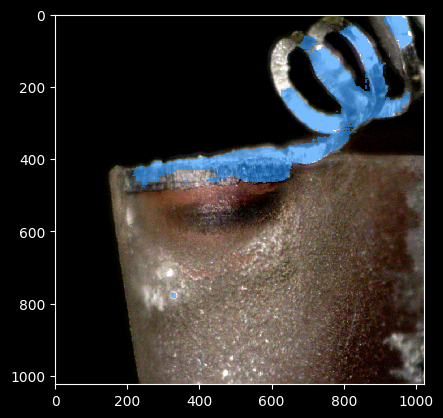

In [15]:
# predict with sam
predictor.set_image(image)
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    mask_input=outputs_lowres.squeeze(0).cpu().detach().numpy(),
    multimask_output=False,
)
plt.imshow(image)
show_mask(masks, plt.gca())
iou = 1 - iou_loss(torch.from_numpy(masks).unsqueeze(0).float().cuda(), torch.from_numpy(gt/255).unsqueeze(0).unsqueeze(0).float().cuda()).item()
iou_threshold = 1 - iou_loss((torch.from_numpy(masks).unsqueeze(0).float().cuda() > 0.5).float(), torch.from_numpy(gt/255).unsqueeze(0).unsqueeze(0).float().cuda()).item()
print(f"IoU: {iou:.4f}, IoU threshold: {iou_threshold:.4f}")
predictor.reset_image()

In [16]:
from scipy.ndimage import label, center_of_mass, sum
from skimage.measure import find_contours, points_in_poly

def convert_and_swap(input_data):
    if isinstance(input_data, tuple):
        # 如果输入是单个元组
        return [input_data[1], input_data[0]]
    elif isinstance(input_data, list):
        # 如果输入是元组的列表
        return [[item[1], item[0]] for item in input_data]
    elif isinstance(input_data, np.ndarray) and input_data.shape == (2,):
        # 如果输入是一个numpy数组形状为(2,)
        return [input_data[1], input_data[0]]
    else:
        raise TypeError(f"Expected input_data to be a tuple, list, or a numpy array of shape (2,), but got {type(input_data)}")
    

from skimage.morphology import erosion, disk

def shrink_mask(mask):
    """
    Erodes the mask until it reduces to a very small region or even to a single point.
    """
    last_non_empty_mask = mask.copy()  # Keep track of the last non-empty state
    while np.sum(mask) > 1:
        mask = erosion(mask, disk(1))
        
        # Check if mask is empty after erosion
        if np.sum(mask) == 0:
            mask = last_non_empty_mask
            break

        last_non_empty_mask = mask.copy()

    return np.argwhere(mask)


def find_centroids_shrink_mask(pre_mask, ratio=0.1):
    labeled_mask, num_features = label(pre_mask)
    
    # Calculate area sizes
    area_sizes = np.bincount(labeled_mask.ravel())[1:]
    
    # Calculate the total mask area
    total_mask_area = np.sum(pre_mask)
    
    # Compute the threshold based on the ratio
    area_threshold = ratio * total_mask_area

    # 获取面积大于 area_threshold 的连通区域标签
    large_region_labels = np.where(area_sizes > area_threshold)[0] + 1  # +1 to offset the background label

    # 初始化中心点列表
    large_region_centroids = []

    # 获取这些连通区域的中心坐标
    for region_label in large_region_labels:
        mask_for_region = labeled_mask == region_label
        
        # Shrinking the mask for this region to get the point
        point = shrink_mask(mask_for_region)
        
        # The point is a list of coordinates where the mask is 1. 
        # Since we've shrunk it down to a single point, we just take the first item.
        centroid = point[0]
        
        # 将新的中心点添加到中心点列表
        large_region_centroids.append(centroid)
            
    return labeled_mask, large_region_labels, large_region_centroids




In [17]:
from skimage.draw import line

def intersection_points(mask, start_point, direction_vector):
    end_point = start_point + 1000 * direction_vector
    rr, cc = line(int(start_point[0]), int(start_point[1]), int(end_point[0]), int(end_point[1]))
    
    # Ensure the values are within the mask boundaries
    valid_indices = (rr >= 0) & (rr < mask.shape[0]) & (cc >= 0) & (cc < mask.shape[1])
    rr = rr[valid_indices]
    cc = cc[valid_indices]

    # Check if the arrays are empty
    if not rr.size or not cc.size:
        return np.array([])

    intersected = mask[rr, cc]
    intersected_indices = np.where(intersected)[0]
    rr_intersected = rr[intersected_indices]
    cc_intersected = cc[intersected_indices]

    intersection_coords = np.column_stack((rr_intersected, cc_intersected))
    
    return intersection_coords


def adjusted_centroid(mask, gravity_centroid):
    contours = find_contours(mask, 0.5)
    if len(contours) == 0:
        return gravity_centroid
    
    longest_contour = sorted(contours, key=lambda x: len(x))[-1]
    
    if points_in_poly([gravity_centroid], longest_contour).any():
        return gravity_centroid
    
    nearest_boundary_point = closest_boundary_point(mask, gravity_centroid)
    direction_vector = nearest_boundary_point - gravity_centroid
    direction_vector /= np.linalg.norm(direction_vector)
    intersections = intersection_points(mask, gravity_centroid, direction_vector)
    
    if len(intersections) < 2:
        return gravity_centroid  # Safety fallback
    
    return np.mean(intersections, axis=0)

def closest_boundary_point(mask, point):
    # 1. Identify the contours of the mask.
    contours = find_contours(mask, 0.5)
    
    # 2. If no contours are found, simply return the given point.
    if len(contours) == 0:
        return point
    
    # 3. Sort the contours based on their length and pick the longest one.
    longest_contour = sorted(contours, key=lambda x: len(x))[-1]

    # 4. For each point on the contour, calculate its distance from the given point.
    distances = np.linalg.norm(longest_contour - point, axis=1)
    
    # 5. Select the contour point that has the shortest distance to the given point.
    nearest_boundary_point = longest_contour[np.argmin(distances)]

    return nearest_boundary_point


def find_centroids_gravity_center_adjusted(pre_mask, ratio=0.1):
    labeled_mask, num_features = label(pre_mask)
    area_sizes = np.bincount(labeled_mask.ravel())[1:]
    total_mask_area = np.sum(pre_mask)
    area_threshold = ratio * total_mask_area
    large_region_labels = np.where(area_sizes > area_threshold)[0] + 1  # +1 to offset the background label
    large_region_centroids = []

    for region_label in large_region_labels:
        gravity_centroid = center_of_mass(pre_mask, labeled_mask, region_label)
        ensured_point = adjusted_centroid(pre_mask , gravity_centroid)
        large_region_centroids.append(ensured_point)

    return labeled_mask, large_region_labels, large_region_centroids

In [18]:
def bisect_region(mask, centroid, direction_vector):
    """Bisects the mask along the direction_vector starting from the centroid."""
    new_mask = mask.copy()
    
    end_point1 = centroid + 1000 * direction_vector
    end_point2 = centroid - 1000 * direction_vector
    rr, cc = line(int(end_point1[0]), int(end_point1[1]), int(end_point2[0]), int(end_point2[1]))
    
    valid_indices = (rr >= 0) & (rr < mask.shape[0]) & (cc >= 0) & (cc < mask.shape[1])
    rr = rr[valid_indices]
    cc = cc[valid_indices]

    # Set to 0 (cut) along the line
    new_mask[rr, cc] = 0
    return new_mask

def closest_boundary_point(mask, point):
    # 1. Identify the contours of the mask.
    contours = find_contours(mask, 0.5)
    
    # 2. If no contours are found, simply return the given point.
    if len(contours) == 0:
        return point
    
    # 3. Sort the contours based on their length and pick the longest one.
    longest_contour = sorted(contours, key=lambda x: len(x))[-1]

    # 4. For each point on the contour, calculate its distance from the given point.
    distances = np.linalg.norm(longest_contour - point, axis=1)
    
    # 5. Select the contour point that has the shortest distance to the given point.
    nearest_boundary_point = longest_contour[np.argmin(distances)]

    return nearest_boundary_point

def is_on_boundary(point, contour):
    """Check if a point is on a contour."""
    return any(np.all(point == contour_pt) for contour_pt in contour)

def check_and_adjust_centroids(mask, depth=0, max_depth=3):

    if depth >= max_depth:
        return []
    
    labeled_mask, num_features = label(mask)
    centroids = []

    for region_label in range(1, num_features + 1):
        region_mask = (labeled_mask == region_label)
        gravity_centroid = center_of_mass(region_mask)

        # Visualization
        plt.imshow(region_mask, cmap='gray')
        contours = find_contours(region_mask, 0.1)[0]
        plt.plot(contours[:, 1], contours[:, 0], 'b-', linewidth=2)
        plt.scatter(gravity_centroid[1], gravity_centroid[0], color='red', s=50)
        plt.title(f"Region {region_label} with Gravity Centroid")
        plt.show()

        y, x = int(gravity_centroid[0]), int(gravity_centroid[1])
        is_inside = region_mask[y, x]
        on_boundary = is_on_boundary(gravity_centroid, contours)

        if not is_inside:
            if on_boundary:
                # Find another boundary point and compute the perpendicular direction
                nearest_boundary_point = closest_boundary_point(region_mask, gravity_centroid)
                direction_vector = nearest_boundary_point - gravity_centroid
                perpendicular_vector = np.array([-direction_vector[1], direction_vector[0]])
                cut_mask = bisect_region(mask, gravity_centroid, perpendicular_vector)
            else:
                nearest_boundary_point = closest_boundary_point(region_mask, gravity_centroid)
                direction_vector = nearest_boundary_point - gravity_centroid
                cut_mask = bisect_region(mask, gravity_centroid, direction_vector)
            centroids += check_and_adjust_centroids(cut_mask)
        else:
            centroids.append(gravity_centroid)

    return centroids


def find_centroids_gravity_center_recursive(pre_mask, ratio=0.1):
    labeled_mask, num_features = label(pre_mask)
    area_sizes = np.bincount(labeled_mask.ravel())[1:]
    total_mask_area = np.sum(pre_mask)
    area_threshold = ratio * total_mask_area
    large_region_indices = np.where(area_sizes > area_threshold)[0] + 1

    large_region_centroids = []
    large_region_labels = []
    for region_label in large_region_indices:
        region_mask = (labeled_mask == region_label)
        current_centroids = check_and_adjust_centroids(region_mask)
        large_region_centroids += current_centroids
        large_region_labels += [region_label] * (len(current_centroids))

    return labeled_mask, large_region_labels, large_region_centroids


使用中心点和延长点

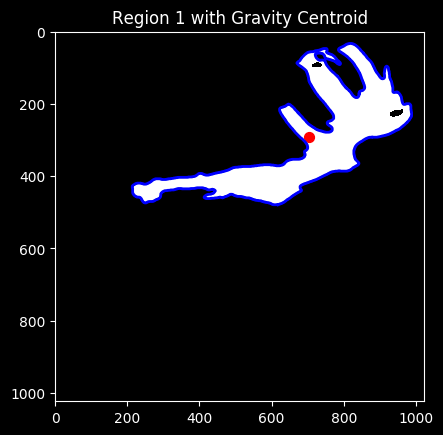

[4]
[(291.06445450838146, 703.4852546629178)]


In [19]:
pre_mask = pre.squeeze().cpu().detach().numpy()

labeled_mask, large_region_labels, large_region_centroids = find_centroids_gravity_center_recursive(pre_mask)
print(large_region_labels)
print(large_region_centroids)

[-43.49978601 702.79312568] [516.49925172 702.61314711]
[288.28571523 578.02451829] [290.21129944 998.99958326]
centroid: [703.4852546629178, 291.06445450838146]


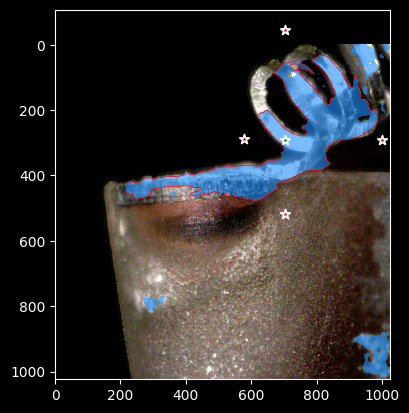

In [20]:
import numpy as np
import matplotlib.pyplot as plt


def extend_point(centroid, point, extension_length):
    # Compute the direction vector from the centroid to the point
    direction = point - centroid
    
    # Normalize the direction vector
    normalized_direction = direction / np.linalg.norm(direction)
    
    # Scale it by the extension length
    extended_vector = normalized_direction * extension_length
    
    # Compute the new extended point
    extended_point = point + extended_vector
    
    return extended_point


extension_length = 100
points_list = []
label_list = []

padding = 5  # Specify the amount of padding
for region_label, centroid in zip(large_region_labels, large_region_centroids):
    # Get the mask of the current region
    mask_for_region = labeled_mask == region_label
    
    # Pad the mask
    padded_mask = np.pad(mask_for_region, padding, mode='constant', constant_values=0)
    
    # Find contours on the padded mask
    contours = find_contours(padded_mask, 0.5)
    
    # Get the longest contour and adjust its coordinates due to padding
    longest_contour = sorted(contours, key=lambda x: len(x))[-1]
    longest_contour -= padding
    
    # Plot the contour
    plt.plot(longest_contour[:, 1], longest_contour[:, 0], '-r', linewidth=0.5)
    
    # Find points with the same x-coordinate as the centroid
    horizontal_points = [point for point in longest_contour if np.abs(point[1] - centroid[1]) < 1]
    
    # Find points with the same y-coordinate as the centroid
    vertical_points = [point for point in longest_contour if np.abs(point[0] - centroid[0]) < 1]
    
    # Get the top and bottom points by y-coordinate
    if horizontal_points:
        horizontal_points_sorted = sorted(horizontal_points, key=lambda x: x[0])
        bottom_point = horizontal_points_sorted[0]
        top_point = horizontal_points_sorted[-1]
        bottom_point = extend_point(centroid, horizontal_points_sorted[0], extension_length)
        top_point = extend_point(centroid, horizontal_points_sorted[-1], extension_length)
        print(bottom_point, top_point)
        bottom_point, top_point = convert_and_swap(bottom_point), convert_and_swap(top_point)
        points_list.extend([top_point, bottom_point])
        label_list.extend([0, 0])
    
    # Get the left and right points by x-coordinate
    if vertical_points:
        vertical_points_sorted = sorted(vertical_points, key=lambda x: x[1])
        left_point = vertical_points_sorted[0]
        right_point = vertical_points_sorted[-1]
        left_point = extend_point(centroid, vertical_points_sorted[0], extension_length)
        right_point = extend_point(centroid, vertical_points_sorted[-1], extension_length)
        print(left_point, right_point)
        left_point, right_point = convert_and_swap(left_point), convert_and_swap(right_point)
        points_list.extend([left_point, right_point])
        label_list.extend([0, 0])

    centroid = convert_and_swap(centroid)
    print(f"centroid: {centroid}")
    points_list.append(centroid)
    label_list.append(1)
# Display the result
input_point = np.array(points_list) if len(points_list) > 0 else None
input_label = np.array(label_list) if len(label_list) > 0 else None

plt.imshow(image)
show_mask(pre_mask, plt.gca())
show_points(input_point, input_label, plt.gca())


IoU: 0.1975, IoU threshold: 0.1975


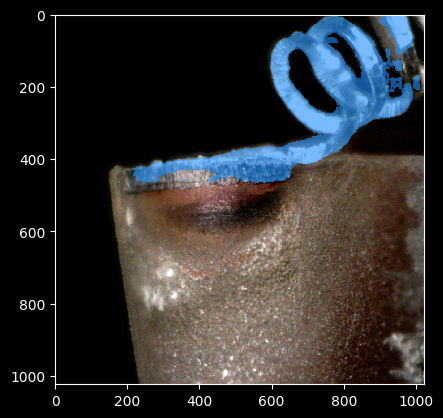

In [21]:
# predict with sam
predictor.set_image(image)
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=outputs_lowres.squeeze(0).cpu().detach().numpy(),
    multimask_output=False,
)
plt.imshow(image)
show_mask(masks, plt.gca())
iou = 1 - iou_loss(torch.from_numpy(masks).unsqueeze(0).float().cuda(), torch.from_numpy(gt/255).unsqueeze(0).unsqueeze(0).float().cuda()).item()
iou_threshold = 1 - iou_loss((torch.from_numpy(masks).unsqueeze(0).float().cuda() > 0.5).float(), torch.from_numpy(gt/255).unsqueeze(0).unsqueeze(0).float().cuda()).item()
print(f"IoU: {iou:.4f}, IoU threshold: {iou_threshold:.4f}")
predictor.reset_image()

只使用中心点

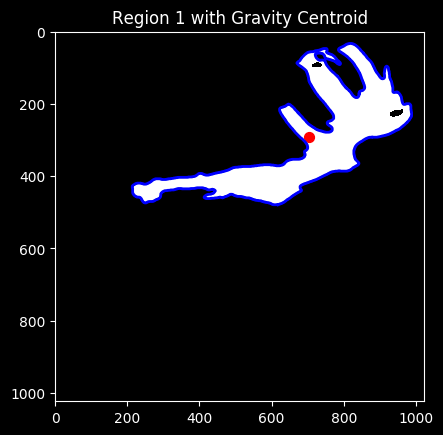

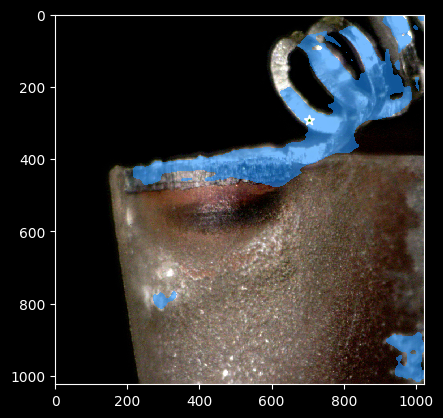

In [22]:
import numpy as np
from scipy.ndimage import label

pre_mask = pre.squeeze().cpu().detach().numpy()
labeled_mask, num_features = label(pre_mask)

# 获取这些连通区域的中心坐标
_, _, centroids = find_centroids_gravity_center_recursive(pre_mask)

centroids = convert_and_swap(centroids)

input_point = np.array(centroids) if len(centroids) > 0 else None
input_label = np.array([1 for _ in range(len(input_point))]) if input_point is not None else None

plt.imshow(image)
show_mask(pre_mask, plt.gca())
show_points(input_point, input_label, plt.gca())


IoU: 0.0240, IoU threshold: 0.0240


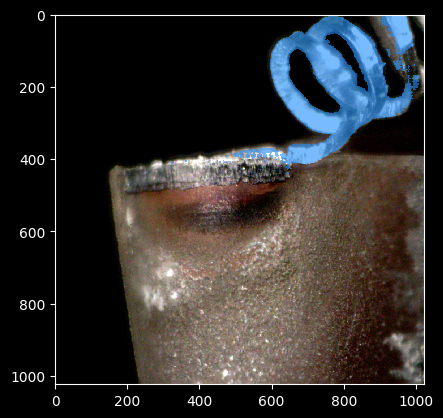

In [23]:
# predict with sam
predictor.set_image(image)
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=outputs_lowres.squeeze(0).cpu().detach().numpy(),
    multimask_output=False,
)
plt.imshow(image)
show_mask(masks, plt.gca())
iou = 1 - iou_loss(torch.from_numpy(masks).unsqueeze(0).float().cuda(), torch.from_numpy(gt/255).unsqueeze(0).unsqueeze(0).float().cuda()).item()
iou_threshold = 1 - iou_loss((torch.from_numpy(masks).unsqueeze(0).float().cuda() > 0.5).float(), torch.from_numpy(gt/255).unsqueeze(0).unsqueeze(0).float().cuda()).item()
print(f"IoU: {iou:.4f}, IoU threshold: {iou_threshold:.4f}")
predictor.reset_image()